In [1]:
import numpy as np
import pandas as pd

from scipy.signal import correlate, correlation_lags
from scipy.optimize import curve_fit

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from astropy.table import Table

from cesium.time_series import TimeSeries
import cesium.featurize as featurize

from collections import defaultdict, OrderedDict
import random
import time
import multiprocessing

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


# Dataset

In [4]:
class LightCurveDataset(Dataset):
    def __init__(self, data_file=None, metadata_file=None):
        self.metadata = pd.read_csv(metadata_file, dtype=defaultdict(lambda : np.float32, {'object_id': np.int32, 'ddf': bool, 'target': np.int8}))
        # Let's remap the target labels in the metadata file
        # remap_classes = {6: 0, 15: 1, 16: 2, 42: 3, 52: 4, 53: 5, 62: 6, 64: 7, 65: 8, 67: 9, 88: 10, 90: 11, 92: 12, 95:13, 99: 14}
        # self.metadata['target'] = self.metadata['target'].map(remap_classes)
        self.data = pd.read_csv(data_file, dtype={'object_id': np.int32, 'mjd': np.float64, 'passband': np.int8, 
                                                  'flux': np.float32, 'flux_err': np.float32, 'detected': bool})
        # Let's also remap the passbands
        remap_passbands = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
        self.data['passband'] = self.data['passband'].map(remap_passbands)
        # Let's drop the detected column
        self.data = self.data.drop(columns='detected')
        # # Let's shift and scale the fluxes and flux errors for each object
        # # Also let's note the flux magnitudes before scaling
        # self.data['flux'] = self.data.groupby(['object_id', 'passband'])['flux'].transform(lambda x: x - x.min())
        # self.data['flux_mag'] = self.data.groupby(['object_id','passband'])['flux'].transform('max')
        # self.data['flux'] = self.data['flux'] / self.data['flux_mag'].max()
        # self.data['flux_err'] = self.data['flux_err'] / self.data['flux_mag'].max()
        # # Let's also scale the flux magnitudes across passbands
        # self.data['flux_mag'] = self.data.groupby(['object_id'])['flux_mag'].transform(lambda x: x / x.max())
        # # Let's sort the data by mjd
        self.data.sort_values(by='mjd', inplace=True)
        # # Let's shift the days from start
        # self.data['mjd'] = self.data.groupby('object_id')['mjd'].transform(lambda x: x - x.min())
        # # And scale them for no reason whatsoever
        # self.data['mjd'] = self.data['mjd'] / self.data['mjd'].max()
        return

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Grab the metadata of the i-th object
        feature_count = 6
        out_tensor = torch.zeros((len(lcd), feature_count))
        out_tensor[:, 0:2] = self.metadata_tensor[idx, 7:9]
        out_tensor[:, 2:6] = self.data_tensor[idx, ]
        return out_tensor, torch.tensor(md['target'])

In [407]:
# Load the training data
train_lcd = LightCurveDataset(metadata_file='./training/training_set_metadata.csv',
                              data_file='./training/training_set.csv')

In [7]:
# test_batch1_lcd = LightCurveDataset(metadata_file='/kaggle/input/PLAsTiCC-2018/test_set_metadata.csv',
#                               data_file='/kaggle/input/PLAsTiCC-2018/test_set_batch1.csv')

In [8]:
# test_batch1_lcd.data['object_id'].unique()[100:200]

## Finding supernova observation block:

In [173]:
def find_supernova_block(ts, obs_block_threshold=80):
    # Given the data for an object, return the block of observations corresponding to a supernova
    df = ts.copy()
    df['group'] = (df['mjd'].diff() > obs_block_threshold).cumsum()
    ewms = []
    tables = []
    for grp, table in df.groupby('group'):
        if len(table) < 3:
            continue
        # Use variance weighted mean
        ewms.append(np.average(table['flux'], weights=1 / table['flux_err'] ** 2))
        tables.append(table)
    return tables[np.argmax(ewms)]

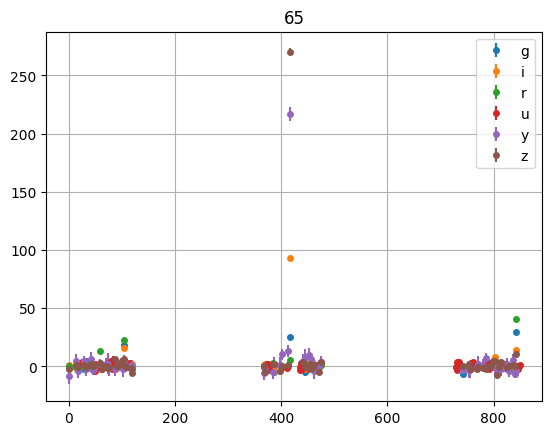

In [285]:
# array([ 6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95])
n = 65
random_obj_id = train_lcd.metadata[(train_lcd.metadata['target'] == n) & (train_lcd.metadata['ddf'] == True)]['object_id'].sample().iloc[0]
df = train_lcd.data[train_lcd.data['object_id'] == random_obj_id]
# fig, axs = plt.subplots(1, 2)
for pb, subtable in df.groupby('passband'):
    plt.errorbar(subtable['mjd'] - df['mjd'].min(), subtable['flux'], subtable['flux_err'], marker='o', markersize=4, linestyle='none', label=pb)
plt.title(n)
plt.legend()
plt.grid()
# axs[1].plot(df['mjd'].diff().dropna())
# axs[1].set_ylabel('t[i+1] - t[i]')
# axs[1].set_title('Difference in days between consecutive observations')
# axs[1].grid()
# fig.set_size_inches(16, 4)
plt.show()

265397


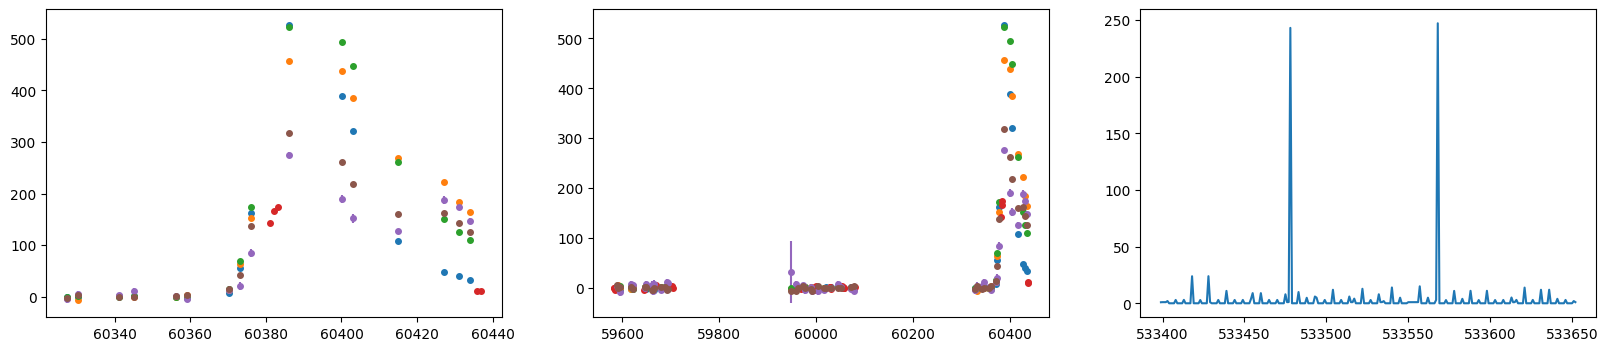

In [311]:
random_obj_id = train_lcd.metadata[(train_lcd.metadata['target'] == 90) & (train_lcd.metadata['ddf'] == True)]['object_id'].sample().iloc[0]
print(random_obj_id)
sdf = find_supernova_block(train_lcd.data[train_lcd.data['object_id'] == random_obj_id])
fig, axs = plt.subplots(1, 3)
for pb, subtable in sdf.groupby('passband'):
    axs[0].errorbar(subtable['mjd'], subtable['flux'], subtable['flux_err'], marker='o', markersize=4, linestyle='none', label=pb)
# plt.legend()
# plt.show()
for pb, subtable in train_lcd.data[train_lcd.data['object_id'] == random_obj_id].groupby('passband'):
    axs[1].errorbar(subtable['mjd'], subtable['flux'], subtable['flux_err'], marker='o', markersize=4, linestyle='none', label=pb)
# axs[0].legend()
# axs[1].legend()
axs[2].plot(train_lcd.data[train_lcd.data['object_id'] == random_obj_id]['mjd'].diff().dropna())
fig.set_size_inches(20, 4)
plt.show()

In [13]:
for obj_id in tqdm(train_lcd.metadata[train_lcd.metadata['target'] == 90]['object_id']):
    sdf = find_supernova_block(train_lcd.data[train_lcd.data['object_id'] == obj_id])

  0%|          | 0/2313 [00:00<?, ?it/s]

## Bazin fit:

$$
f(t) = \Lambda\left[\frac{\exp\left(\frac{-(t-t_0)}{t_{fall}}\right)}{1+\exp\left(\frac{-(t-t_0)}{t_{rise}}\right)}\right] + \Phi
$$

$$
t_0 = t_{max} - t_{rise} \times \ln \left(\frac{t_{fall}}{t_{rise} - 1}\right)
$$

In [335]:
# def bazin_curve(t, t_rise, t_fall, loc, scale, shift):
    # return scale * np.exp(-(t - loc) / t_fall) / (1 + np.exp(-(t - loc) / t_rise)) + shift

def bazin_curve(t, t_rise, t_fall, loc, scale, shift):
    return scale / (np.exp((t - loc) / t_fall) + np.exp((t - loc) * (1 / t_fall - 1 / t_rise))) + shift

g [ 9.81026481e+00  2.58975026e+01  6.01468114e+04  2.51051228e+03
 -1.31808077e+01]
i [ 1.03884815e+01  4.60074490e+01  6.01443832e+04  1.99686306e+03
 -8.72322371e+00]
r [ 1.04325561e+01  3.45102103e+01  6.01465700e+04  2.49649409e+03
 -8.27063340e+00]
u [1.10683278e+01 1.60980292e+01 6.01547835e+04 1.96671710e+03
 7.66160353e-01]
y [9.73872752e+00 5.93869315e+01 6.01452732e+04 1.29472103e+03
 5.95167167e+01]
z [1.01494241e+01 5.45019006e+01 6.01440337e+04 1.57719048e+03
 2.50671990e+01]


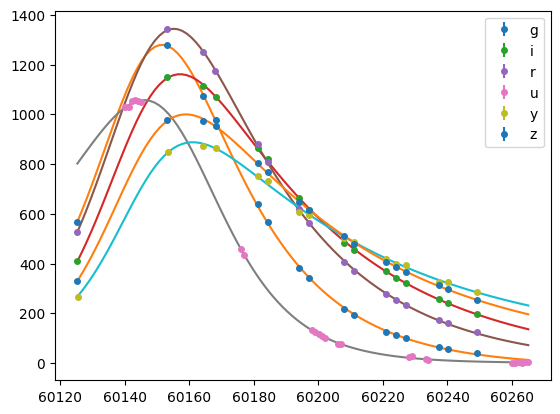

In [337]:
random_obj_id = train_lcd.metadata[(train_lcd.metadata['target'] == 95) & (train_lcd.metadata['ddf'] == True)]['object_id'].sample().iloc[0]
# random_obj_id = 245506
sdf = find_supernova_block(train_lcd.data[train_lcd.data['object_id'] == random_obj_id])
for pb, subtable in sdf.groupby('passband'):
    plt.errorbar(subtable['mjd'], subtable['flux'], subtable['flux_err'], marker='o', markersize=4, linestyle='none', label=pb)
    # print(subtable[['mjd','flux']])
    popt, _ = curve_fit(bazin_curve, subtable['mjd'],
                        subtable['flux'],
                        p0=(7, 20, subtable.iloc[subtable['flux'].argmax(), 1], subtable['flux'].max(), 0),
                        bounds=([0, 0, -np.inf, 0, -np.inf],
                                [np.inf, np.inf, np.inf, np.inf, np.inf]))
    print(pb, popt)
    x = np.linspace(sdf['mjd'].min(), sdf['mjd'].max(), 100)
    plt.plot(x, bazin_curve(x, *popt))
plt.legend()
plt.show()

Bazin fit seems like it's working really terribly.

## Lag plots for periodic data:

The hypothesis is that just picking the longest block of observations works. After that, try making lag plots.

Consider redshift correction like $t/(1+z)$

In [203]:
def maxcorr_ppamp(ts):
    # Find the maximum peak-to-peak cross-correlation amplitude in each band for consecutive blocks
    return np.median(correlate(ts['flux'], ts['flux']))
    # df = ts.copy()
    # df.sort_values(by='mjd',inplace=True)
    # df['group'] = (df['mjd'].diff() > 80).cumsum()
    # tables = []
    # for grp, table in df.groupby('group'):
    #     table['flux_err'] = table['flux_err'] / (table['flux'].max() - table['flux'].min())
    #     table['flux'] = (table['flux'] - table['flux'].min()) / (table['flux'].max() - table['flux'].min())
    #     tables.append(table)
    # maxcorrs = []
    # for i in range(len(tables) - 1):
    #     corr = correlate(tables[i]['flux'], tables[i + 1]['flux'])
    #     maxcorrs.append(np.max(np.abs(corr) / len(corr)))
    # return np.min(maxcorrs)

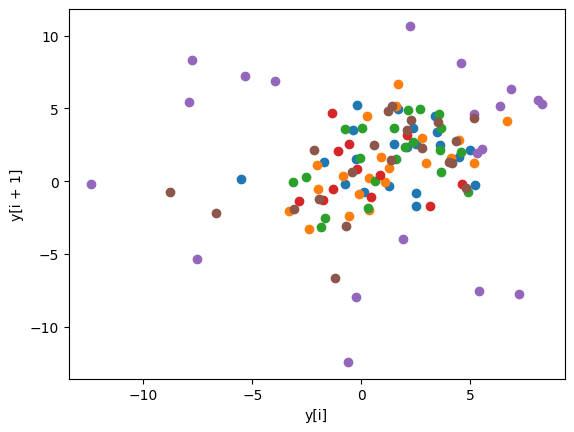

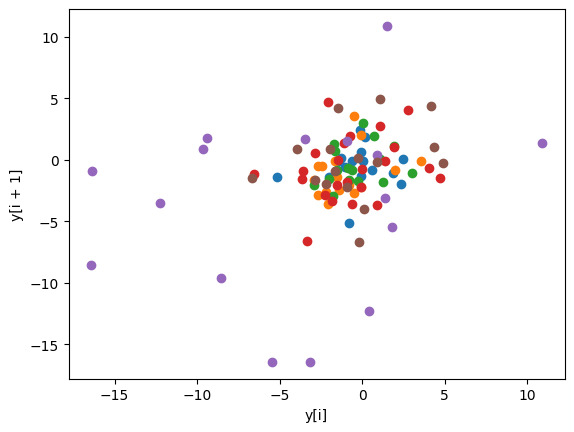

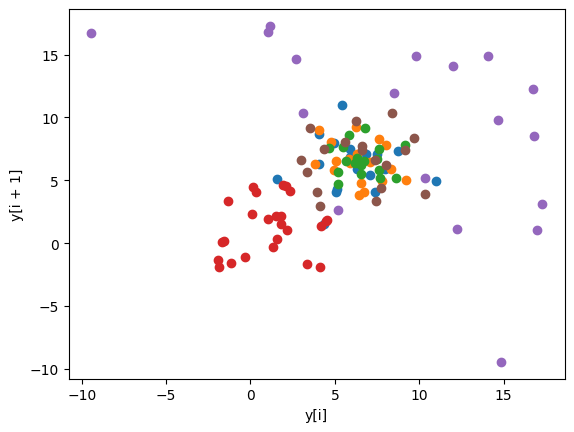

In [437]:
random_obj_id = train_lcd.metadata[(train_lcd.metadata['target'] == 88) & (train_lcd.metadata['ddf'] == True)]['object_id'].sample().iloc[0]
# print(random_obj_id)
ts = train_lcd.data[train_lcd.data['object_id'] == random_obj_id]
# maxcorr_ppamp(ts)
df = ts.copy()
# df = df[df['flux'].abs() < 100]
df.sort_values(by='mjd',inplace=True)
df['group'] = (df['mjd'].diff() > 80).cumsum()
for grp, table in df.groupby('group'):
    for pb, subtable in table.groupby('passband'):
        plt.scatter(subtable['flux'].iloc[:-1], subtable['flux'].iloc[1:])
    plt.xlabel('y[i]')
    plt.ylabel('y[i + 1]')
    # x = np.linspace(table['flux'].min(), table['flux'].max())
    # plt.plot(x, x)
    plt.show()

In [205]:
random_obj_id = train_lcd.metadata[(train_lcd.metadata['target'] == ) & (train_lcd.metadata['ddf'] == True)]['object_id'].sample().iloc[0]
# print(random_obj_id)
ts = train_lcd.data[train_lcd.data['object_id'] == random_obj_id]
df = ts.copy()
df['group'] = (df['mjd'].diff() > 80).cumsum()
tables = []
for grp, table in df.groupby('group'):
    tables.append(table)
    # for pb, subtable in table.groupby('passband'):
    #     plt.errorbar(subtable['mjd'], subtable['flux'], subtable['flux_err'], marker='o', markersize=4, linestyle='none', label=pb)
    # plt.legend()
    # plt.show()
for i in range(len(tables) - 1):
    corr = correlate(tables[i]['flux'] / tables[i]['flux'].max(), tables[i + 1]['flux'] / tables[i + 1]['flux'].max())
    lags = correlation_lags(len(tables[i]), len(tables[i + 1]))
    plt.plot(lags, corr / len(corr), label=f'({i}, {i + 1})')
plt.legend()
plt.show()

SyntaxError: invalid syntax (1851478763.py, line 1)

## Random forest classifier:

Follows the starter kit

In [13]:
pbmap = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'Y')])

# it also helps to have passbands associated with a color
pbcols = OrderedDict([(0,'blueviolet'), (1,'green'), (2,'red'),\
                      (3,'orange'), (4, 'black'), (5, 'brown')])

pbnames = list(pbmap.values())

In [389]:
datadir = './others'
metafilename = './training/training_set_metadata.csv'
metadata = Table.read(metafilename, format='csv')
metadata = metadata[(metadata['target'] == 90) | (metadata['target'] == 42) | (metadata['target'] == 65) | (metadata['target'] == 15)
                     | (metadata['target'] == 62) | (metadata['target'] == 67) | (metadata['target'] == 52) | (metadata['target'] == 95)
                     | (metadata['target'] == 6) | (metadata['target'] == 64)]
nobjects = len(metadata)
# Create supertargets
supertarget_map = {53: 1, 88: 2, 16: 3, 92: 4, # periodic
                   90: 1, 42: 2, 65: 3, 15: 4, 62: 5, 67: 6, 52: 7, 95: 8, 6: 9, 64: 10} # transient
supertargets = metadata.to_pandas()['target'].map(supertarget_map).to_numpy()
metadata.add_column(supertargets, name='supertarget')

In [391]:
lcfilename = './training/training_set.csv'
lcdata = Table.read(lcfilename, format='csv')

In [392]:
def time_series_worker(i):
    row = metadata[i]
    thisid = row['object_id']
    target = row['target']
    supertarget = row['supertarget']
    
    ind = (lcdata['object_id'] == thisid)
    thislc = lcdata[ind]

    meta = {'z':row['hostgal_photoz'], 'zerr':row['hostgal_photoz_err'], 'mwebv':row['mwebv']}

    pbind = [(thislc['passband'] == pb) for pb in pbmap]
    t = [thislc['mjd'][mask].data for mask in pbind]
    m = [thislc['flux'][mask].data for mask in pbind]
    e = [thislc['flux_err'][mask].data for mask in pbind]

    ts = TimeSeries(t=t, m=m, e=e, label=target, name=thisid, meta_features=meta, channel_names=pbnames)
    return thisid, ts

tsdict = OrderedDict()

features_list = []
with tqdm(total=nobjects, desc='Building Timeseries') as pbar:
    with multiprocessing.Pool() as pool:
        results = pool.imap(time_series_worker, list(range(nobjects)))
        for thisid, ts in results:
            tsdict[thisid] = ts
            pbar.update()

Building Timeseries:   0%|          | 0/6285 [00:00<?, ?it/s]

In [393]:
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average",
                  ]

In [394]:
def general_feature_extraction_worker(tsobj):
    global features_to_use
    thisfeats = featurize.featurize_single_ts(tsobj, features_to_use=features_to_use, raise_exceptions=False)
    return thisfeats

featurefile = f'general_featuretable.npz'
# if os.path.exists(featurefile):
#     featuretable, _ = featurize.load_featureset(featurefile)
# else:
features_list = []
with tqdm(total=nobjects, desc="Computing Features") as pbar:
    with multiprocessing.Pool() as pool:  
        results = pool.imap(general_feature_extraction_worker, list(tsdict.values()))
        for res in results:
            features_list.append(res)
            pbar.update()
        
featuretable = featurize.assemble_featureset(features_list=features_list, time_series=tsdict.values())
    # featurize.save_featureset(fset=featuretable, path=featurefile)

Computing Features:   0%|          | 0/6285 [00:00<?, ?it/s]

In [395]:
old_names = featuretable.columns.values
new_names = ['{}_{}'.format(x, pbmap.get(y,'meta')) for x,y in old_names]
cols = [featuretable[col] for col in old_names]
allfeats = Table(cols, names=new_names)

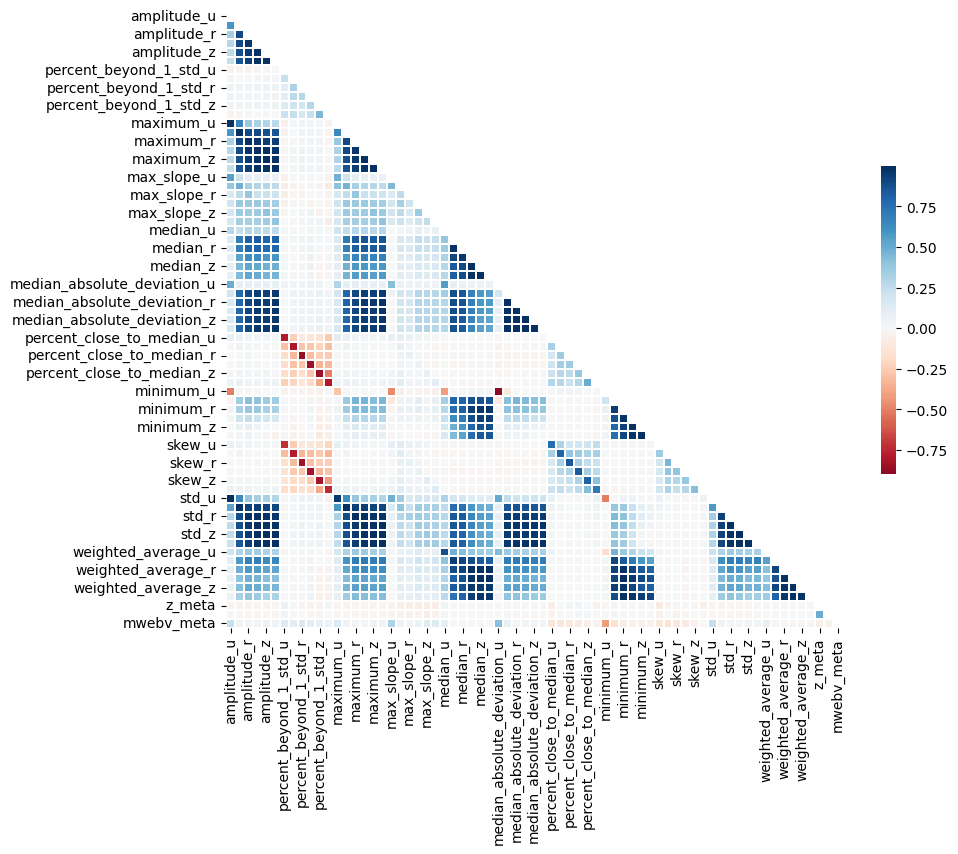

In [396]:
corr = allfeats.to_pandas().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
corr_plot = sns.heatmap(corr, mask=mask, cmap='RdBu', center=0,
                square=True, linewidths=.2, cbar_kws={"shrink": .5})

In [397]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
splits = list(splitter.split(allfeats, metadata['supertarget']))[0]
train_ind, test_ind = splits

In [398]:
Xtrain = np.array(allfeats[train_ind].as_array().tolist())
Ytrain = np.array(metadata['supertarget'][train_ind].tolist())

Xtest  = np.array(allfeats[test_ind].as_array().tolist())
Ytest  = np.array(metadata['supertarget'][test_ind].tolist())

In [399]:
ncols = len(new_names)
npca  = (ncols  - 3)//len(pbnames)  + 3
print(ncols, npca)

69 14


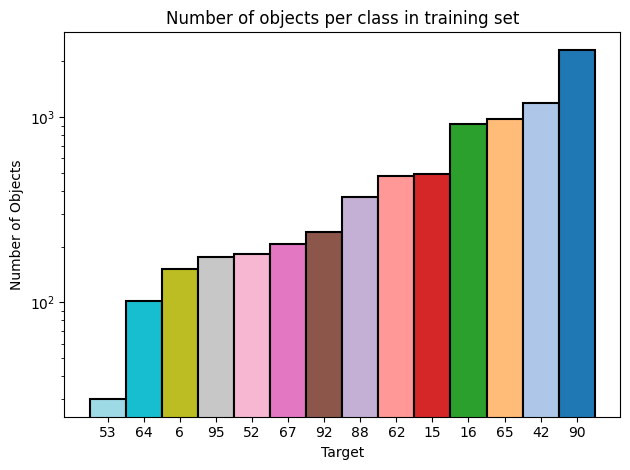

In [114]:
from collections import Counter
from operator import itemgetter
counts = Counter(metadata['target'])
labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))
fig, ax = plt.subplots()

cmap = plt.cm.tab20
nlines = len(labels)
classcolor =  list(cmap(np.linspace(0,1,nlines)))[::-1]

# we'll create a mapping between class and color
classcolmap = dict(zip(labels, classcolor))

indexes = np.arange(nlines)
width = 1
ax.bar(indexes, values, width, edgecolor='k',\
       linewidth=1.5, tick_label=labels, log=True, color=classcolor)
ax.set_xlabel('Target')
ax.set_ylabel('Number of Objects')
ax.set_title('Number of objects per class in training set')
fig.tight_layout()

In [400]:
pca = PCA(n_components=npca, whiten=True, svd_solver="full", random_state=42)
Xtrain_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)

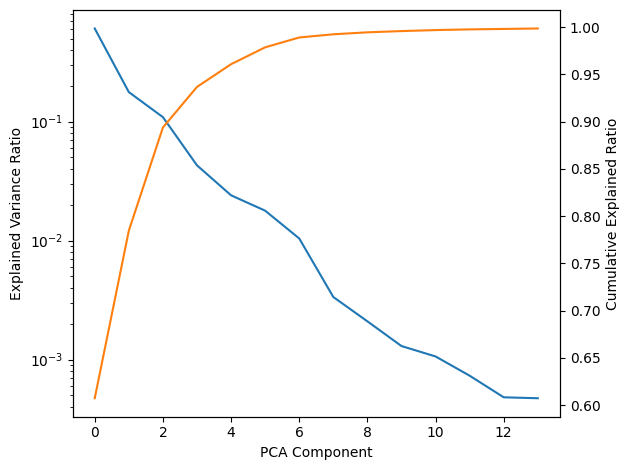

In [401]:
fig, ax = plt.subplots()
ax.plot(np.arange(npca), pca.explained_variance_ratio_, color='C0')
ax2 = ax.twinx()
ax2.plot(np.arange(npca), np.cumsum(pca.explained_variance_ratio_), color='C1')
ax.set_yscale('log')
ax.set_xlabel('PCA Component')
ax.set_ylabel('Explained Variance Ratio')
ax2.set_ylabel('Cumulative Explained Ratio')
fig.tight_layout()

In [402]:
clf = RandomForestClassifier(n_estimators=200, criterion='gini', oob_score=True, n_jobs=-1, random_state=42, verbose=1, class_weight='balanced')

In [403]:
clf.fit(Xtrain_pca, Ytrain)
Ypred = clf.predict(Xtest_pca)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


In [404]:
cm = confusion_matrix(Ytest, Ypred, labels=list(range(1, 11)))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

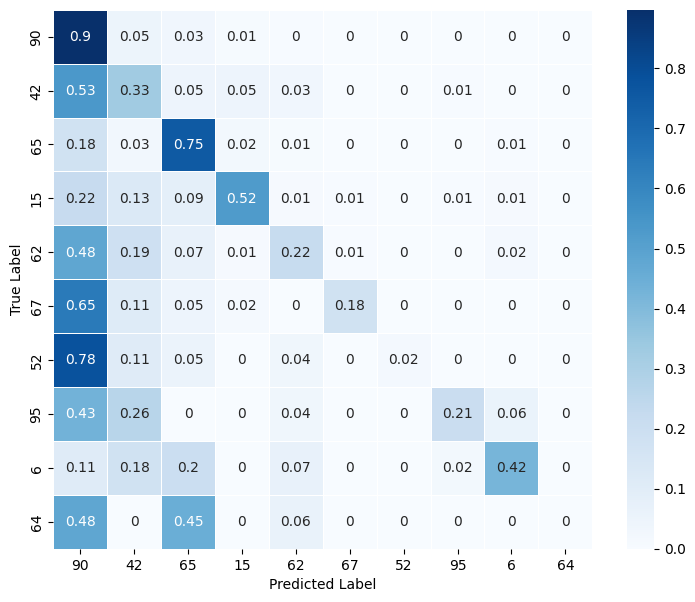

In [405]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(data=cm, xticklabels=[90, 42, 65, 15, 62, 67, 52, 95, 6, 64], yticklabels=[90, 42, 65, 15, 62, 67, 52, 95, 6, 64], cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

# Model

I hope object IDs in the test set are not split across multiple batches...

In [ ]:
class AstroRNN(nn.Module):
    def __init__(self):
        super(AstroRNN, self).__init__()
        self.input_layer = nn.LSTM(6, 64, num_layers=2, bidirectional=True)
        self.activation = nn.ReLU()
        self.linear_layer = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, 14)

    def forward(self, input_tensor):
        rnn_out, hidden = self.input_layer(input_tensor)
        logits = self.activation(rnn_out[-1, :])
        logits = self.activation(self.linear_layer(logits))
        logits = self.activation(self.output_layer(logits))
        return logits

In [ ]:
# The way I'm doing it, it's possible I don't get certain classes
train_set, test_set = torch.utils.data.random_split(train_lcd, [.80, .20], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

In [ ]:
def train(rnn, training_data, n_epoch = 50, n_batch_size = 64, report_every = 1, learning_rate = 0.4):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    rnn.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.8, total_iters=n_epoch)

    start = time.time()
    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) // n_batch_size)

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #for each example in this batch
                (input_tensor, label) = training_data[i]
                output = rnn.forward(input_tensor)
                loss = criterion(output, label)
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches))
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0
        # before_lr = optimizer.param_groups[0]["lr"]
        # scheduler.step()
        # after_lr = optimizer.param_groups[0]["lr"]
        # print("Epoch %d: SGD lr %.4f -> %.4f" % (iter, before_lr, after_lr))

    return all_losses

In [ ]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (input_tensor, label) = testing_data[i]
            output = rnn(input_tensor)
            output = nn.functional.softmax(output, dim=0)
            for i, v in enumerate(output):
                confusion[label][i] += v

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

In [ ]:
rnn = AstroRNN()
rnn.to(device)
all_losses = train(rnn, train_set)

In [ ]:
evaluate(rnn, test_set, list(range(14)))

# Data Exploration

In [ ]:
a_ = train_lcd.data[(train_lcd.data['object_id'] == 1091307)].mjd.to_numpy()
a_ = np.sort(a_)
plt.plot(np.diff(a_))
# This really just means I can use 50 days as a safe parameter to split observations

In [ ]:
train_lcd.data[train_lcd.data['object_id'] == 615].drop(columns='object_id').to_numpy()

In [18]:
train_lcd.data

,object_id,mjd,passband,flux,flux_err
1003642,56654981,59580.0343,y,-74.560371,85.404518
1312459,111660438,59580.0347,y,-41.952148,81.836311
853318,29000971,59580.0347,y,227.867340,80.876534
1154854,83890499,59580.0347,y,-30.211102,79.263763
700486,2776284,59580.0347,y,-144.815872,82.954010
...,...,...,...,...,...
910679,39389857,60674.3625,y,-81.556023,65.790451
1273076,104808447,60674.3625,y,-36.205315,65.029968
1341679,116880255,60674.3625,y,-37.022861,65.185081
829777,24271581,60674.3625,y,-272.367371,80.494286


In [7]:
test_batch1_lcd = LightCurveDataset(metadata_file='./test/test_set_metadata.csv',
                              data_file='./test/test_set_batch1.csv')

In [8]:
print(test_batch1_lcd.metadata['hostgal_specz'].count() / len(test_batch1_lcd.metadata))
print(train_lcd.metadata['hostgal_specz'].count() / len(train_lcd.metadata))

0.03446801931924567
1.0


In [9]:
print(test_batch1_lcd.metadata['ddf'].value_counts() / len(test_batch1_lcd.metadata))
print(train_lcd.metadata['ddf'].value_counts() / len(train_lcd.metadata))

ddf
False    0.990573
True     0.009427
Name: count, dtype: float64
ddf
False    0.730377
True     0.269623
Name: count, dtype: float64


In [ ]:
spec_photo = train_set_md[(train_set_md['hostgal_specz'].isna() == False) & (train_set_md['hostgal_specz'] < 1)]
spec_photo = spec_photo[['hostgal_specz', 'hostgal_photoz']].to_numpy()

In [ ]:
sns.jointplot(x=spec_photo[:,0],y=spec_photo[:,1],alpha=0.5)
plt.xlabel('hostgal_specz')
plt.ylabel('hostgal_photoz')
plt.show()

In [ ]:
extragal = train_set_md[train_set_md['hostgal_specz'] > 0.0]
extragal['zratio'] = extragal['hostgal_photoz'] / extragal['hostgal_specz']
sns.jointplot(x=extragal['mwebv'].to_numpy(), y=extragal['zratio'].to_numpy())

In [ ]:
extragal[extragal['zratio']> 1.5].hist(column='zratio',by='target',figsize=(8,8),sharex=True,sharey=True)
plt.show()

In [ ]:
vals = []
for (obj_id, passband), table in train_lcd.data.groupby(by=['object_id', 'passband']):
    vals.append([len(table), (table['mjd'].max() - table['mjd'].min()) / (len(table) - 1), passband, train_lcd.metadata.loc[train_lcd.metadata['object_id'] == obj_id, 'ddf'].to_numpy()[0]])
df = pd.DataFrame(vals, columns=['num_obs', 'avg_sampling_time', 'passband', 'ddf'])

In [ ]:
sns.stripplot(data=df, x='passband', y='avg_sampling_time', hue='ddf', alpha=0.2, jitter=False)
plt.show()

In [ ]:
sns.stripplot(data=df, x='passband', y='num_obs', hue='ddf', alpha=0.5, jitter=False)
plt.show()